In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the MNIST dataset.
It has handwritten digits in the range 0-9. The images in MNIST are of
size 1x28x28, i.e. greyscale images of 28x28 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a Feed-Forward Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing MNIST

Using ``torchvision``, it’s extremely easy to load MNIST.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Let us show some of the training images, for fun.



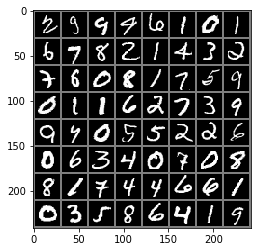

 2  9  9  9  6  1  0  1  6  7  8  2  1  4  3  2  7  6  0  8  1  7  5  9  0  1  1  6  2  7  3  9  9  4  0  5  5  2  2  6  0  6  3  4  0  7  0  8  8  1  7  4  4  6  6  1  0  3  5  8  6  4  1  9


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%2s' % classes[labels[j]] for j in range(64)))

In [5]:
images[0].size()

torch.Size([1, 28, 28])

2. Define a Neural Network
-----------------------------------------
Copy the neural network from the Neural Networks section before.



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
---------------------------------------
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
--------------------

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        net.train()
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            net.eval()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


5. Test the network on the test data
------------------------------------

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



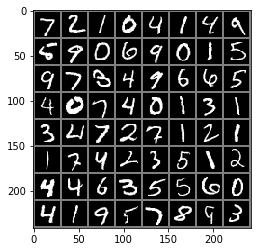

GroundTruth:   7  2  1  0  4  1  4  9  5  9  0  6  9  0  1  5  9  7  3  4  9  6  6  5  4  0  7  4  0  1  3  1  3  4  7  2  7  1  2  1  1  7  4  2  3  5  1  2  4  4  6  3  5  5  6  0  4  1  9  5  7  8  9  3


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%2s' % classes[labels[j]] for j in range(64)))

Okay, now let us see what the neural network thinks these examples above are:



In [10]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [12]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 97 %
Accuracy of     2 : 85 %
Accuracy of     3 : 87 %
Accuracy of     4 : 91 %
Accuracy of     5 : 82 %
Accuracy of     6 : 89 %
Accuracy of     7 : 89 %
Accuracy of     8 : 95 %
Accuracy of     9 : 84 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        net.train()
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            net.eval()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   101] loss: 0.017
[1,   201] loss: 0.017
[1,   301] loss: 0.016
[1,   401] loss: 0.017
[1,   501] loss: 0.017
[1,   601] loss: 0.016
[1,   701] loss: 0.017
[1,   801] loss: 0.015
[1,   901] loss: 0.015
[2,     1] loss: 0.000
[2,   101] loss: 0.015
[2,   201] loss: 0.015
[2,   301] loss: 0.015
[2,   401] loss: 0.015
[2,   501] loss: 0.015
[2,   601] loss: 0.015
[2,   701] loss: 0.015
[2,   801] loss: 0.015
[2,   901] loss: 0.013
Finished Training
